In [1]:
%matplotlib inline
# %matplotlib widget
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy.spatial
import pandas as pd
import sklearn.decomposition
import matplotlib.pyplot as plt
# import keras
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances,mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from utils.readProfiles import readMergedProfiles
from utils.pred_models import *
from utils.visualize_cells import *
from utils.saveAsNewSheetToExistingFile import saveAsNewSheetToExistingFile
from multiprocessing import Pool
import rcca
from sklearn.cluster import KMeans
sns.set_style("whitegrid")
# from utils import networksEvol, tsne, readProfiles
import umap

In [34]:
''.join(['1','2','3'])

'123'

In [119]:
# img.shape
pd.__version__

'1.3.2'

### Paths

In [2]:
procProf_dir='/home/ubuntu/datasetsbucket/Rosetta-GE-CP/'
# procProf_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/'
metadata_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/metadata/'

### Read data

In [3]:
################################################
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS', 'CDRP-bio'
# datasets=['LUAD', 'TAORF', 'LINCS', 'CDRP-bio'];
dataset='LINCS'

################################################
# CP Profile Type options: 'augmented' , 'normalized', 'normalized_variable_selected'
profileType='normalized_variable_selected'

################################################
# filtering to compounds which have high replicates for both GE and CP datasets
highRepOverlapEnabled=1


################################################
pertColName='PERT'
profileLevel='treatment'; #'replicate'  or  'treatment'

nRep=2
repLevel,mergProf_treatLevel,cp_features,l1k_features=\
readMergedProfiles(procProf_dir,dataset,profileType,profileLevel,nRep,highRepOverlapEnabled);


# l1k=mergProf_treatLevel[[pertColName,'det_plate']+l1k_features]
# cp=mergProf_treatLevel[[pertColName,'Metadata_Plate']+cp_features]

l1k=mergProf_treatLevel[[pertColName]+l1k_features]
cp=mergProf_treatLevel[[pertColName]+cp_features]


if dataset=='LINCS':     
    cp['Compounds']=cp['PERT'].str[0:13]
    l1k['Compounds']=l1k['PERT'].str[0:13]
else:
    cp['Compounds']=cp['PERT']
    l1k['Compounds']=l1k['PERT']      


le = preprocessing.LabelEncoder()
group_labels=le.fit_transform(l1k['Compounds'].values)


scaler_ge = preprocessing.StandardScaler()
scaler_cp = preprocessing.StandardScaler()
l1k_scaled=l1k.copy()
l1k_scaled[l1k_features] = scaler_ge.fit_transform(l1k[l1k_features].values)
cp_scaled=cp.copy()
cp_scaled[cp_features] = scaler_cp.fit_transform(cp[cp_features].values.astype('float64'))

/tmp/ipykernel_81889/1368118665.py:21: DtypeWarning: Columns (18,19,1249,1250) have mixed types.Specify dtype option on import or set low_memory=False.
  readMergedProfiles(procProf_dir,dataset,profileType,profileLevel,nRep,highRepOverlapEnabled);


LINCS: Replicate Level Shapes (nSamples x nFeatures): cp:  51455 , 121 ,  l1k:  27837 , 978
l1k n of rep:  3.0
cp n of rep:  5.0
CP: from  9394  to  4647
l1k: from  8369  to  2338
CP and l1k high rep overlap:  1140
Treatment Level Shapes (nSamples x nFeatures+metadata): (1141, 124) (1141, 980) Merged Profiles Shape: (1141, 1103)


/tmp/ipykernel_81889/1368118665.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cp['Compounds']=cp['PERT'].str[0:13]
/tmp/ipykernel_81889/1368118665.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l1k['Compounds']=l1k['PERT'].str[0:13]


In [7]:
#############################
cp_scaled['split']=''
cp_scaled.loc[cp_scaled['PERT'].isin(diverse_perts),'split']='train'
cp_scaled.loc[cp_scaled['PERT'].isin(test_perts),'split']='test'
cp_scaled.loc[cp_scaled['PERT']=='DMSO','split']='DMSO'

l1k_scaled['split']=''
l1k_scaled.loc[l1k_scaled['PERT'].isin(diverse_perts),'split']='train'
l1k_scaled.loc[l1k_scaled['PERT'].isin(test_perts),'split']='test'
l1k_scaled.loc[l1k_scaled['PERT']=='DMSO','split']='DMSO'

In [36]:
# merged_scaled=pd.concat([cp_shared, l1k_shared], axis=0)
# mergProf_treatLevel.shape
# mergProf_treatLevel[[pertColName,'Metadata_Plate']+cp_features]
x=np.array([pert_FINAL_list_93.count(l) for l in pert_FINAL_list_93])
np.where(x==2)

(array([ 5,  6, 33, 49]),)

In [37]:
# pert_FINAL_list_93

In [30]:
pert_FINAL_list_93-list(set(pert_FINAL_list_93))

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [27]:
cp_scaled[cp_scaled['PERT'].isin(pert_FINAL_list_93)].shape

(91, 123)

In [29]:
len(pert_FINAL_list_93)

93

### Apply Kernel CCA

In [5]:
# """Attributes:
# reg (float): regularization parameter. Default is 0.1.
# numCC (int): number of canonical dimensions to keep. Default is 10.
# kernelcca (bool): kernel or non-kernel CCA. Default is True.
# ktype (string): type of kernel used if kernelcca is True.
#                 Value can be 'linear' (default) or 'gaussian'.

# Create a cca object as an instantiation of the CCA object class. 
nComponents = 40

# cca = rcca.CCA(kernelcca = True, reg = 0, numCC = nComponents,ktype='gaussian')
cca = rcca.CCA(kernelcca = False,reg = 0, numCC = nComponents)

# Use the train() method to find a CCA mapping between the two training sets.
train=[cp_scaled[cp_features].values, l1k_scaled[l1k_features].values]
# train=[cp_scaled[cp_features].values[0:1000,:], l1k_scaled[l1k_features].values[0:1000,:]]
# test=[cp_scaled[cp_features].values[1000:,:], l1k_scaled[l1k_features].values[1000:,:]]
cca.train(train)

# Use the validate() method to test how well the CCA mapping generalizes to the test data.
# For each dimension in the test data, correlations between predicted and actual data are computed.
# testcorrs = cca.validate(test)
# print(testcorrs)


######################
cp_shared=pd.DataFrame(data=cca.comps[0],columns=range(nComponents))
cp_shared['PERT']=cp['PERT']
cp_shared['modality']='CP'
l1k_shared=pd.DataFrame(data=cca.comps[1],columns=range(nComponents))
l1k_shared['PERT']=l1k['PERT']
l1k_shared['modality']='GE'
merged_shared=pd.concat([cp_shared, l1k_shared], axis=0)


merged_shared['split']=''
# merged_shared.loc[merged_shared['PERT'].isin(diverse_perts),'split']='train'
# merged_shared.loc[merged_shared['PERT'].isin(test_perts),'split']='test'
# merged_shared.loc[merged_shared['PERT']=='DMSO','split']='DMSO'

Training CCA, kernel = None, regularization = 0.0000, 40 components


In [62]:
testcorrs[0].shape,testcorrs[1].shape

((119,), (978,))

In [7]:
cp_scaled.shape

(26687, 122)

In [65]:
cca.corrs[0].shape,cca.corrs[1].shape

((119,), (978,))

In [70]:
# testcorrs[1],cca.corrs[1]

In [90]:
pd.__version__

'1.3.2'

In [51]:
# # Initialize a cca object as an instantiation of the CCACrossValidate class.
# ccaCV = rcca.CCACrossValidate(kernelcca=True, numCCs = [10, 20, 30, 40,50,60,70,80],
#                               regs = [0.,1e1, 1e2,1e3, 1e4,1e5, 1e6])

# # Use the train() and validate() methods to run the analysis and perform cross-dataset prediction.
# ccaCV.train(train)
# # testcorrsCV = ccaCV.validate([test1, test2])
# print('Optimal number of components: %d\nOptimal regularization coefficient: %d' % (ccaCV.best_numCC, ccaCV.best_reg))

### Find best number of clusters on the shared space using elbow method

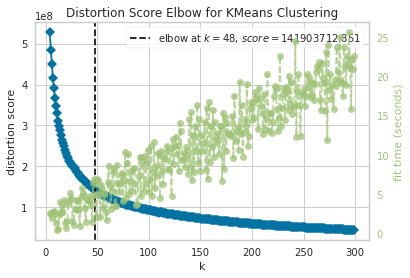

In [10]:

# from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# visualizer = KElbowVisualizer(
#     model, k=(10,200), metric='calinski_harabasz', timings=False
# )
visualizer = KElbowVisualizer(model, k=(4,300))

visualizer.fit(np.concatenate((cca.comps[0],cca.comps[1]),axis=0))        # Fit the data to the visualizer
visualizer.show()

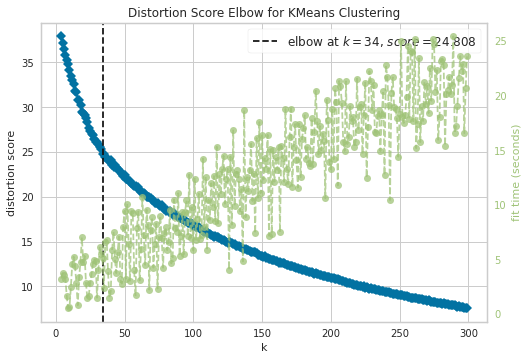

In [7]:
# from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# visualizer = KElbowVisualizer(
#     model, k=(10,200), metric='calinski_harabasz', timings=False
# )
visualizer = KElbowVisualizer(model, k=(4,300))

visualizer.fit(np.concatenate((cca.comps[0],cca.comps[1]),axis=0))        # Fit the data to the visualizer
visualizer.show()

In [15]:
cca.cancorrs

array([0.99952633, 0.9991287 , 0.999045  , 0.99883151, 0.99878574,
       0.99854218, 0.99837526, 0.99789709, 0.99768315, 0.99726901,
       0.99700127, 0.99694018, 0.99670009, 0.99647578, 0.99627516,
       0.99566296, 0.99527311, 0.99492095, 0.99448438, 0.99411987,
       0.99356919, 0.99330238, 0.99301449, 0.99231869, 0.99200171,
       0.99179008, 0.99140222, 0.99091464, 0.99025106, 0.98944365,
       0.98928351, 0.98866596, 0.98841669, 0.98742295, 0.98678126,
       0.98593765, 0.98577272, 0.98529234, 0.98408066, 0.98371255])

In [ ]:
np.concatenate((cca.comps[0],cca.comps[1]),axis=0)

In [109]:
np.concatenate((kmeans_cp.labels_,kmeans_cp.labels_),axis=0).shape

(2282,)

In [30]:
# merged_shared[range(nComponents)]
# cluster_labels.shape[0]/2
# merged_shared

### Apply kmeans using the found K

In [6]:
# elbow_found_k=34
elbow_found_k=100
kmeans = KMeans(n_clusters=elbow_found_k, random_state=0).fit(merged_shared[range(nComponents)])
kmeans_cp = KMeans(n_clusters=elbow_found_k, random_state=0).fit(cp_scaled[cp_features].values)
kmeans_l1k = KMeans(n_clusters=elbow_found_k, random_state=0).fit(l1k_scaled[l1k_features].values)

cluster_labels=kmeans.labels_
merged_shared['cluster']=cluster_labels
merged_shared['cluster_cp']=np.concatenate((kmeans_cp.labels_,kmeans_cp.labels_),axis=0)
merged_shared['cluster_l1k']=np.concatenate((kmeans_l1k.labels_,kmeans_l1k.labels_),axis=0)

cp_cls_labels=cluster_labels[0:int(cluster_labels.shape[0]/2)]
l1k_cls_labels=cluster_labels[int(cluster_labels.shape[0]/2):]

diff_clust=cp_cls_labels-l1k_cls_labels
cca_approved_perts=list(cp_shared.PERT.values[np.where(diff_clust==0)])+['DMSO']

cp_scaled['cluster']=cp_cls_labels
l1k_scaled['cluster']=l1k_cls_labels

cp_scaled['cluster_cp']=kmeans_cp.labels_
l1k_scaled['cluster_cp']=kmeans_cp.labels_

cp_scaled['cluster_l1k']=kmeans_l1k.labels_
l1k_scaled['cluster_l1k']=kmeans_l1k.labels_

In [13]:
print(cp_cls_labels)
print(l1k_cls_labels)

[1 1 1 ... 2 2 2]
[1 1 1 ... 2 2 2]


In [79]:
np.where(diff_clust==0)[0].shape

(1135,)

In [73]:
len(cca_approved_perts)
# cp_shared
# cca_approved_perts

1136

In [69]:
# np.where(diff_clust==0)[0].shape
cp_shared.shape,merged_shared[merged_shared['modality']=='CP'].shape

((1141, 42), (1141, 43))

### Filter to the perts that fall into the same cluster

### Umap of Data in shared and original spaces for filtered samples

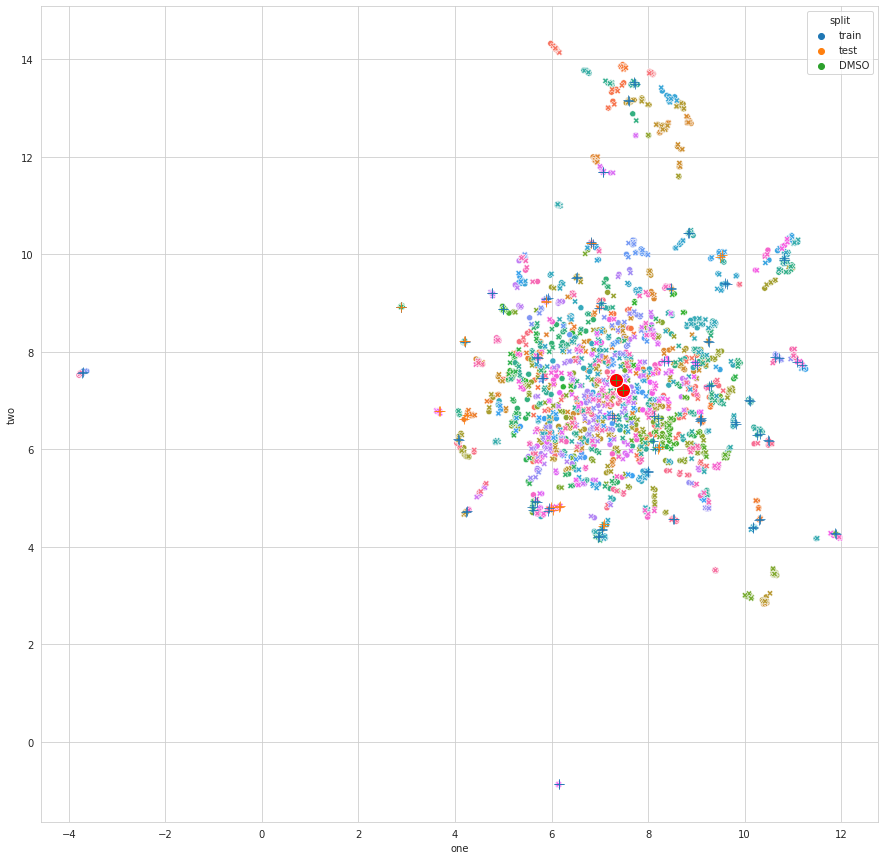

In [9]:
umapT=umap.UMAP()
Y = umapT.fit_transform(merged_shared[range(nComponents)])
merged_shared['one']=Y[:,0]
merged_shared['two']=Y[:,1]
plt.figure(figsize=(15,15))
sns.scatterplot(x="one", y="two", hue="PERT",style="modality", data=merged_shared,legend=False);
sns.scatterplot(x="one", y="two", data=merged_shared[merged_shared['PERT']=='DMSO'],color='r',s=200, marker="o");
sns.scatterplot(x="one", y="two", hue="split", data=merged_shared[merged_shared['split']!=''],s=100, marker="+");

# plt.show()

In [173]:
import plotly.express as px
fig = px.scatter(merged_shared, x="one", y="two",hover_data=['cluster','PERT','split','cluster_cp','cluster_l1k'],\
                 color="cluster",text="split",width=1000, height=1000)
# fig = px.scatter(l1k_scaled_filtered[l1k_scaled_filtered['PERT']=='DMSO'], x="one", y="two",hover_data=['cluster','PERT'])
fig.show()

In [191]:
# merged_shared

In [15]:
# cp_scaled_filtered['split']

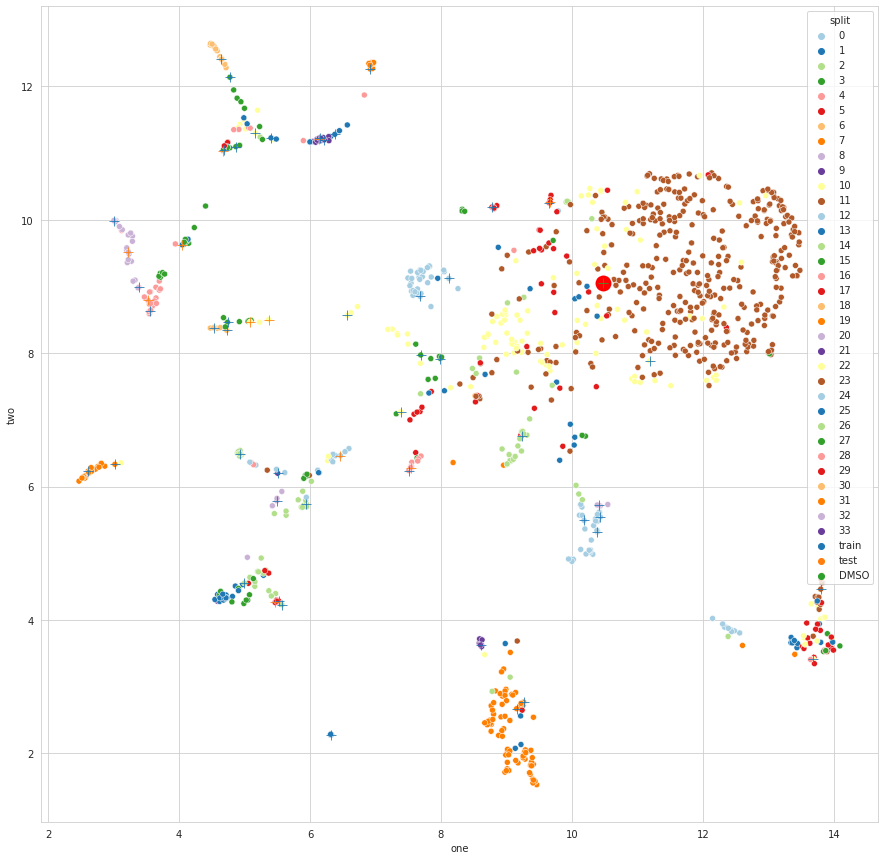

In [80]:
umapT=umap.UMAP()
cp_scaled_filtered=cp_scaled[cp_scaled['PERT'].isin(cca_approved_perts)].reset_index(drop=True)
Y = umapT.fit_transform(cp_scaled_filtered[cp_features])
cp_scaled_filtered['one']=Y[:,0]
cp_scaled_filtered['two']=Y[:,1]
plt.figure(figsize=(15,15))
sns.scatterplot(x="one", y="two", hue="cluster", data=cp_scaled_filtered,legend=True,palette='Paired');
sns.scatterplot(x="one", y="two", data=cp_scaled_filtered[cp_scaled_filtered['PERT']=='DMSO'],color='r',s=300, marker="o");
sns.scatterplot(x="one", y="two", hue="split", data=cp_scaled_filtered[cp_scaled_filtered['split']!=''],s=100, marker="+");

In [ ]:
# sns.scatterplot(x="one", y="two", hue="cluster", data=cp_scaled_filtered,legend=True,palette='Paired');
# sns.scatterplot(x="one", y="two", data=cp_scaled_filtered[cp_scaled_filtered['PERT']=='DMSO'],color='r',s=400, marker="o");


In [76]:
# cp_scaled_filtered[cp_scaled_filtered['PERT']=='DMSO']

In [81]:
import plotly.express as px
fig = px.scatter(cp_scaled_filtered, x="one", y="two",hover_data=['cluster','cluster_cp','cluster_l1k','PERT'],color="cluster"\
                 ,text="split",width=1000, height=1000)
# fig = px.scatter(l1k_scaled_filtered[l1k_scaled_filtered['PERT']=='DMSO'], x="one", y="two",hover_data=['cluster','PERT'])
fig.show()

In [24]:
l1k_scaled_filtered[l1k_scaled_filtered['PERT']=='DMSO']

Empty DataFrame
Columns: [PERT, 200814_at, 222103_at, 201453_x_at, 204131_s_at, 200059_s_at, 205067_at, 213702_x_at, 214435_x_at, 201334_s_at, 213721_at, 202627_s_at, 217478_s_at, 206254_at, 200602_at, 205581_s_at, 206562_s_at, 205897_at, 203135_at, 204531_s_at, 200882_s_at, 206501_x_at, 207199_at, 209572_s_at, 203110_at, 201841_s_at, 204297_at, 209682_at, 206752_s_at, 209747_at, 204061_at, 208711_s_at, 214062_x_at, 207034_s_at, 204369_at, 200081_s_at, 203277_at, 212287_at, 213191_at, 218995_s_at, 201471_s_at, 200989_at, 204748_at, 210145_at, 200768_s_at, 208624_s_at, 205504_at, 201058_s_at, 200830_at, 200614_at, 200966_x_at, 205026_at, 214447_at, 200807_s_at, 204039_at, 201052_s_at, 203952_at, 202100_at, 37152_at, 208992_s_at, 218457_s_at, 202677_at, 201762_s_at, 203639_s_at, 200622_x_at, 218498_s_at, 203381_s_at, 212740_at, 202332_at, 200711_s_at, 207808_s_at, 207805_s_at, 207535_s_at, 219461_at, 205498_at, 202246_s_at, 218292_s_at, 207238_s_at, 208611_s_at, 202310_s_at, 204695_at, 201746_at, 201693_s_at, 207847_s_at, 209464_at, 203315_at, 204092_s_at, 204995_at, 210105_s_at, 202647_s_at, 221478_at, 201069_at, 211297_s_at, 207419_s_at, 203665_at, 211980_at, 202637_s_at, 205500_at, 201502_s_at, 203927_at, ...]
Index: []

[0 rows x 983 columns]

In [25]:
l1k_scaled_filtered['PERT']

0       BRD-A03506276_0.04
1       BRD-A03506276_0.12
2       BRD-A03506276_0.37
3       BRD-A03506276_1.11
4       BRD-A03506276_3.33
               ...        
1118    BRD-K99792991_0.04
1119    BRD-K99792991_1.11
1120    BRD-K99792991_3.33
1121    BRD-K99964838_3.33
1122    BRD-M80207679_3.33
Name: PERT, Length: 1123, dtype: object

In [67]:
%matplotlib widget
# g.legend(loc='right', bbox_to_anchor=(4, 0), ncol=1, borderaxespad=0.8)
# plt.subplots_adjust(right=.6)

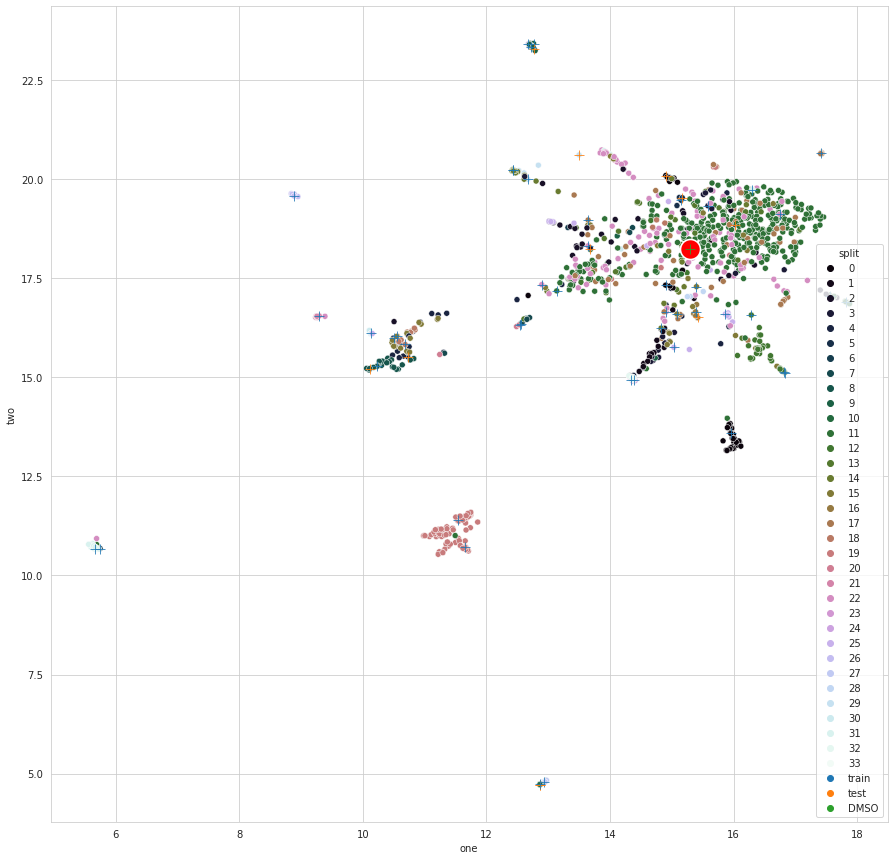

In [13]:
umapT=umap.UMAP()
l1k_scaled_filtered=l1k_scaled[l1k_scaled['PERT'].isin(cca_approved_perts)].reset_index(drop=True)
Y = umapT.fit_transform(l1k_scaled_filtered[l1k_features])
l1k_scaled_filtered['one']=Y[:,0]
l1k_scaled_filtered['two']=Y[:,1]
plt.figure(figsize=(15,15))
qualitative_colors = sns.color_palette("cubehelix", elbow_found_k)
sns.scatterplot(x="one", y="two", hue="cluster", data=l1k_scaled_filtered,legend=True,palette=qualitative_colors);
sns.scatterplot(x="one", y="two", data=l1k_scaled_filtered[l1k_scaled_filtered['PERT']=='DMSO'],color='r',s=400, marker="o");
sns.scatterplot(x="one", y="two", hue="split", data=l1k_scaled_filtered[l1k_scaled_filtered['split']!=''],s=100, marker="+");
plt.show()

In [76]:
# l1k_scaled_filtered

In [16]:
import plotly.express as px
fig = px.scatter(l1k_scaled_filtered, x="one", y="two",hover_data=['cluster','cluster_cp','cluster_l1k','PERT'],color="cluster"
                                 ,text="split",width=1000, height=1000)
# fig = px.scatter(l1k_scaled_filtered[l1k_scaled_filtered['PERT']=='DMSO'], x="one", y="two",hover_data=['cluster','PERT'])
fig.show()

# import plotly.express as px
# df = px.data.iris()
# fig = px.scatter(df, x="sepal_width", y="sepal_length", color="species",
#                  size='petal_length', hover_data=['petal_width'])
# fig.show()

In [74]:
# l1k_scaled_filtered[l1k_scaled_filtered['PERT']=='DMSO']
l1k_scaled_filtered

PERT  200814_at  222103_at  201453_x_at  204131_s_at  \
0     BRD-A03506276_0.04   0.054523  -0.482228    -0.806310    -1.327158   
1     BRD-A03506276_0.12   1.141985  -0.727375    -3.408594    -0.374784   
2     BRD-A03506276_0.37   0.572380  -0.660839     0.493640     0.338325   
3     BRD-A03506276_1.11   0.738007  -0.778102    -2.854889     0.262467   
4     BRD-A03506276_3.33   0.707590  -1.025537     0.722153     1.096551   
...                  ...        ...        ...          ...          ...   
1119  BRD-K99792991_1.11   0.428138  -0.715461     0.510105    -0.888243   
1120  BRD-K99792991_3.33  -0.438871  -1.021596     0.515111    -0.177112   
1121  BRD-K99964838_3.33  -0.280160  -0.558763     0.157868    -0.956799   
1122  BRD-M80207679_3.33  -0.966320  -0.360860    -1.457121    -1.108318   
1123                DMSO  -0.072251   0.264728     0.053452    -0.249294   

      200059_s_at  205067_at  213702_x_at  214435_x_at  201334_s_at  ...  \
0       -1.716060  -0.851952    -0.543062    -0.392722     0.448491  ...   
1       -2.703976   0.426194    -0.690757     0.374699    -0.792572  ...   
2       -1.492509   0.880009    -1.386591     0.098619     0.439906  ...   
3       -0.409593  -0.005442    -1.536147    -0.136520     0.093865  ...   
4       -1.069241   0.812125    -1.066386    -0.087608     0.408700  ...   
...           ...        ...          ...          ...          ...  ...   
1119     0.172335  -0.203244     0.512200     0.904363    -0.432317  ...   
1120    -0.615662   0.164027    -0.015694     2.058672    -0.791508  ...   
1121     1.100288   0.261973    -0.413043     0.373012    -0.001723  ...   
1122    -0.484064   0.814508    -0.492581    -0.221665    -0.658722  ...   
1123     0.063328  -0.227197    -0.227779    -0.305703     0.221007  ...   

      218450_at  212536_at  218529_at  211071_s_at  203341_at  205379_at  \
0     -0.548994  -1.066242   0.510051     1.070324   0.195922   0.253532   
1     -0.816935  -0.169793  -1.913725     0.326810   0.710607   0.804813   
2     -0.895689  -0.348086  -2.866803     0.570141   0.115288   0.944758   
3     -0.701213  -0.969594  -1.802500     0.924460   0.450282   1.379227   
4     -0.848126   1.247304  -2.719211     1.061382   0.481658   1.059408   
...         ...        ...        ...          ...        ...        ...   
1119   0.141287   2.216627   0.639118    -0.509325  -0.747019  -0.183856   
1120   1.447213   0.478087   0.830128     0.726887   0.816390  -0.333070   
1121   0.325366   0.271173  -1.143960     0.415885  -0.657582   0.621562   
1122  -0.914742   0.778103  -0.215858     0.529523   1.316487   0.300046   
1123  -0.180146  -0.102016   0.139984     0.111792   0.019154   0.372062   

          Compounds  cluster        one        two  
0     BRD-A03506276       23  21.568783  12.896956  
1     BRD-A03506276       23  15.522616  19.261158  
2     BRD-A03506276       23  15.485964  19.297525  
3     BRD-A03506276       23  15.486565  19.297699  
4     BRD-A03506276       23  15.496865  19.284521  
...             ...      ...        ...        ...  
1119  BRD-K99792991       25  18.201382  14.198607  
1120  BRD-K99792991       19  17.851757  14.431182  
1121  BRD-K99964838       25  18.742132  13.041843  
1122  BRD-M80207679        1  17.654356  12.664243  
1123           DMSO       25  19.465755  12.752131  

[1124 rows x 983 columns]

In [6]:
diverse_perts=['BRD-K86797399_3.33',
 'BRD-A56085258_3.33',
 'BRD-K68346641_0.12',
 'BRD-K60997853_0.37',
 'BRD-K00259736_0.12',
 'BRD-K78659596_0.37',
 'BRD-K76674262_0.37',
 'BRD-K83699324_1.11',
 'BRD-K43966364_1.11',
 'BRD-A27376179_0.37',
 'BRD-A75172220_0.12',
 'BRD-K23499943_3.33',
 'BRD-A94756469_3.33',
 'BRD-K22848513_3.33',
 'BRD-A05821830_1.11',
 'BRD-K61195623_0.12',
 'BRD-K99113996_0.37',
 'BRD-K79131256_0.37',
 'BRD-A66419424_3.33',
 'BRD-K41783120_1.11',
 'BRD-A03506276_0.37',
#  'BRD-K99964838_3.33', # remove
 'BRD-K13662825_1.11',
 'BRD-K37890730_0.04',
 'BRD-K57080016_0.37',
 'BRD-K47869605_3.33',
 'BRD-K83837640_3.33',
 'BRD-K12867552_0.37',
 'BRD-A28467416_3.33',
 'BRD-K25630527_0.04',
 'BRD-K69776681_0.04',
 'BRD-K59317601_0.37',
 'BRD-K35245662_1.11',
 'BRD-K78055238_0.12',
 'BRD-K18157228_0.04',
 'BRD-K51967704_0.12',
 'BRD-K73088654_1.11',
 'BRD-A74914197_0.04',
 'BRD-K99475619_0.37',
 'BRD-K68488863_3.33',
 'BRD-K53417444_1.11',
 'BRD-K93779381_3.33',
 'BRD-K92428153_1.11',
 'BRD-K83963101_1.11',
 'BRD-K28822270_3.33',
 'BRD-K13183738_3.33',
 'BRD-K15108141_0.12',
 'BRD-K61397605_0.37',
 'BRD-A27376179_1.11']#,"DMSO"]

test_perts=['BRD-A28746609_0.37',  # multiple necleis
'BRD-K83837640_3.33',  # small cells
'BRD-K18157228_1.11',  #big and bright nucleolis
'BRD-K63750851_3.33',    # round but tiny eR dist around nucl
'BRD-K61195623_0.12',      # wiered
'BRD-K41783120_3.33', # sponge like ER network
'BRD-K41213548_3.33', # dotted mito
'BRD-K83837640_0.37', # stretched ER network
'BRD-K37764012_0.37', # one sided ER network
'BRD-K75295174_0.37', # dotted mito network
'BRD-K78567475_3.33']

In [40]:
# l1k_scaled[l1k_scaled['PERT'].isin(diverse_perts)][['PERT','cluster']]

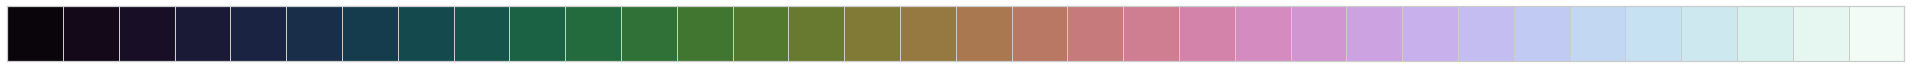

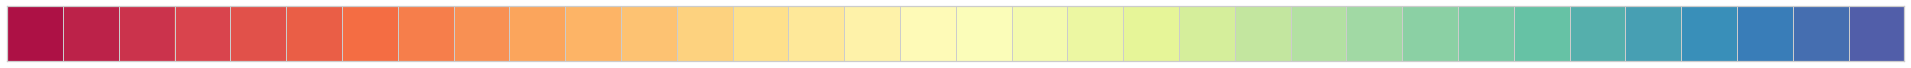

In [64]:
cls = sns.color_palette("cubehelix", elbow_found_k)
sns.palplot(cls)
cls = sns.color_palette("Spectral", elbow_found_k)
sns.palplot(cls)

In [9]:
# perts_forModel=cp_scaled[cp_scaled['split']!=''].reset_index(drop=True)
perts_forModel=cp_scaled.copy()

In [11]:
# perts_forModel.groupby(['cluster']).size()

In [12]:
cluster_dmso,cluster_cp_dmso,cluster_l1k_dmso=perts_forModel[perts_forModel['PERT']=='DMSO'][['cluster','cluster_cp','cluster_l1k']].values[0]

In [13]:
perts_forModel_filtered_toNotIn_dmso_cluster=perts_forModel[~((perts_forModel['cluster']==cluster_dmso)|\
                                                            (perts_forModel['cluster_cp']==cluster_cp_dmso)|\
                                                           (perts_forModel['cluster_l1k']==cluster_l1k_dmso))]

In [28]:
pert_final=perts_forModel_filtered_toNotIn_dmso_cluster.groupby(['cluster']).sample(1).reset_index(drop=True)
pert_final.cluster_cp.unique().shape, pert_final.cluster_l1k.unique().shape

((71,), (61,))

In [161]:
pert_final2=perts_forModel_filtered_toNotIn_dmso_cluster.groupby(['cluster']).sample(1).reset_index(drop=True)
pert_final2.cluster_cp.unique().shape, pert_final2.cluster_l1k.unique().shape

((24,), (20,))

In [134]:
perts_forModel[(perts_forModel['cluster_cp']==cluster_cp_dmso)|\
                                                           (perts_forModel['cluster_l1k']==cluster_l1k_dmso)]

PERT  Cells_AreaShape_Zernike_8_0  \
6   BRD-A56085258_3.33                    -1.233798   
58                DMSO                    -0.453013   

    Cytoplasm_Correlation_Correlation_ER_RNA  Cytoplasm_Granularity_2_RNA  \
6                                   0.060377                     0.850872   
58                                 -0.428069                    -0.001020   

    Nuclei_AreaShape_Zernike_4_4  Cytoplasm_AreaShape_Zernike_1_1  \
6                        0.46339                         1.105543   
58                       0.15598                         0.463061   

    Nuclei_Texture_Correlation_RNA_20_0  Cytoplasm_Correlation_Overlap_ER_AGP  \
6                              0.391806                             -0.650277   
58                            -0.176846                             -0.402567   

    Nuclei_AreaShape_Zernike_2_0  Cytoplasm_Granularity_2_ER  ...  \
6                       0.206452                    0.899378  ...   
58                     -0.265229                    0.481473  ...   

    Cytoplasm_Correlation_Overlap_DNA_RNA  Cells_Texture_InfoMeas2_DNA_20_0  \
6                               -0.179451                          0.147078   
58                              -0.624534                         -0.279998   

    Cells_RadialDistribution_RadialCV_ER_2of4  Nuclei_AreaShape_Zernike_6_6  \
6                                    0.845212                      0.408384   
58                                   0.605946                     -0.074566   

    Nuclei_AreaShape_Zernike_3_1      Compounds  split  cluster  cluster_cp  \
6                       0.598982  BRD-A56085258  train        1          33   
58                      0.468998           DMSO   DMSO        1          33   

    cluster_l1k  
6             8  
58            1  

[2 rows x 125 columns]

In [40]:
# pert_final_2=pert_final.groupby(['cluster_l1k']).sample(1).reset_index(drop=True)
pert_final_2=pert_final.groupby(['cluster_cp']).sample(1).reset_index(drop=True)
# pert_final_2.cluster_cp.unique().shape
pert_final_2.cluster_l1k.unique().shape
# pert_final_2.groupby()

(50,)

In [34]:
pert_final_2.shape

(61, 126)

In [34]:
pert_final_2.groupby(['split']).size()

split
test      3
train    18
dtype: int64

In [2]:
from IPython.display import display, Math, Latex

display(Math(r'F(k) = \int_{-\infty}^{\infty} f(x) e^{2\pi i k} dx'))

<IPython.core.display.Math object>

In [41]:
pert_FINAL_list_22perts=pert_final_2.PERT.tolist()+['DMSO']
pert_FINAL_list_22perts

['BRD-K23363278_0.12',
 'BRD-A05821830_1.11',
 'BRD-K18157228_0.37',
 'BRD-K82746043_0.04',
 'BRD-K93034159_3.33',
 'BRD-K69776681_1.11',
 'BRD-K86797399_3.33',
 'BRD-A28467416_0.12',
 'BRD-K22848513_1.11',
 'BRD-K68552125_1.11',
 'BRD-A15297126_0.04',
 'BRD-K41213548_3.33',
 'BRD-K13662825_1.11',
 'BRD-K41783120_0.12',
 'BRD-K53417444_0.37',
 'BRD-K37687095_3.33',
 'BRD-K11717138_3.33',
 'BRD-A03506276_0.37',
 'BRD-K68488863_3.33',
 'BRD-K61397605_0.04',
 'BRD-K70463136_1.11',
 'BRD-K29968218_0.12',
 'BRD-A36057565_0.37',
 'BRD-K68346641_0.37',
 'BRD-K82244583_1.11',
 'BRD-A48237631_1.11',
 'BRD-A28746609_0.12',
 'BRD-A66419424_1.11',
 'BRD-A28467416_3.33',
 'BRD-K61195623_0.37',
 'BRD-K64800655_0.37',
 'BRD-A79768653_3.33',
 'BRD-K88510285_1.11',
 'BRD-K56957086_0.04',
 'BRD-K37890730_1.11',
 'BRD-K23499943_0.37',
 'BRD-K76674262_0.12',
 'BRD-K59317601_3.33',
 'BRD-K72414522_3.33',
 'BRD-K52233191_3.33',
 'BRD-K47000838_3.33',
 'BRD-K34022604_3.33',
 'BRD-A27376179_3.33',
 'BRD-A9475

In [170]:
pert_FINAL_list_22perts

['BRD-K83837640_3.33',
 'BRD-K22848513_3.33',
 'BRD-K76674262_0.37',
 'BRD-K69776681_0.04',
 'BRD-K61195623_0.12',
 'BRD-K13662825_1.11',
 'BRD-A28467416_3.33',
 'BRD-K23499943_3.33',
 'BRD-A75172220_0.12',
 'BRD-A28746609_0.37',
 'BRD-K41783120_1.11',
 'BRD-K18157228_1.11',
 'BRD-K92428153_1.11',
 'BRD-K93779381_3.33',
 'BRD-K28822270_3.33',
 'BRD-K37890730_0.04',
 'BRD-K78659596_0.37',
 'BRD-K13183738_3.33',
 'BRD-K78055238_0.12',
 'BRD-A94756469_3.33',
 'BRD-K60997853_0.37',
 'DMSO']

In [5]:
pert_FINAL_list_76perts=['BRD-K23363278_0.12',
 'BRD-A05821830_1.11',
 'BRD-K18157228_0.37',
 'BRD-K82746043_0.04',
 'BRD-K93034159_3.33',
 'BRD-K69776681_1.11',
 'BRD-K86797399_3.33',
 'BRD-A28467416_0.12',
 'BRD-K22848513_1.11',
 'BRD-K68552125_1.11',
 'BRD-A15297126_0.04',
 'BRD-K41213548_3.33',
 'BRD-K13662825_1.11',
 'BRD-K41783120_0.12',
 'BRD-K53417444_0.37',
 'BRD-K37687095_3.33',
 'BRD-K11717138_3.33',
 'BRD-A03506276_0.37',
 'BRD-K68488863_3.33',
 'BRD-K61397605_0.04',
 'BRD-K70463136_1.11',
 'BRD-K29968218_0.12',
 'BRD-A36057565_0.37',
 'BRD-K68346641_0.37',
 'BRD-K82244583_1.11',
 'BRD-A48237631_1.11',
 'BRD-A28746609_0.12',
 'BRD-A66419424_1.11',
 'BRD-A28467416_3.33',
 'BRD-K61195623_0.37',
 'BRD-K64800655_0.37',
 'BRD-A79768653_3.33',
 'BRD-K88510285_1.11',
 'BRD-K56957086_0.04',
 'BRD-K37890730_1.11',
 'BRD-K23499943_0.37',
 'BRD-K76674262_0.12',
 'BRD-K59317601_3.33',
 'BRD-K72414522_3.33',
 'BRD-K52233191_3.33',
 'BRD-K47000838_3.33',
 'BRD-K34022604_3.33',
 'BRD-A27376179_3.33',
 'BRD-A94756469_1.11',
 'BRD-K21361524_3.33',
 'BRD-K63750851_3.33',
 'BRD-A36331462_1.11',
 'BRD-K78567475_3.33',
 'BRD-K68488863_1.11',
 'BRD-K73088654_1.11',
 'BRD-K43966364_1.11',
 'BRD-K96123349_0.37',
 'BRD-K37890730_3.33',
 'BRD-A48237631_0.37',
 'BRD-K92303087_3.33',
 'BRD-K41213548_1.11',
 'BRD-K74305673_3.33',
 'BRD-K17743125_0.37',
 'BRD-K37890730_0.12',
 'BRD-K78055238_0.37',
 'BRD-K61397605_3.33',
 'BRD-K58435339_3.33',
 'BRD-K17203476_1.11',
 'BRD-A49765801_3.33',
 'BRD-K07310275_3.33',
 'BRD-A36331462_0.12',
 'BRD-A88138582_1.11',
 'BRD-K59325863_0.37',
 'BRD-K29968218_1.11',
 'BRD-K64890080_0.37',
 'BRD-K52233191_1.11',
 'DMSO']


pert_FINAL_list_22perts=['BRD-K83837640_3.33',
 'BRD-K22848513_3.33',
 'BRD-K76674262_0.37',
 'BRD-K69776681_0.04',
 'BRD-K61195623_0.12',
 'BRD-K13662825_1.11',
 'BRD-A28467416_3.33',
 'BRD-K23499943_3.33',
 'BRD-A75172220_0.12',
 'BRD-A28746609_0.37',
 'BRD-K41783120_1.11',
 'BRD-K18157228_1.11',
 'BRD-K92428153_1.11',
 'BRD-K93779381_3.33',
 'BRD-K28822270_3.33',
 'BRD-K37890730_0.04',
 'BRD-K78659596_0.37',
 'BRD-K13183738_3.33',
 'BRD-K78055238_0.12',
 'BRD-A94756469_3.33',
 'BRD-K60997853_0.37']

In [7]:
pert_FINAL_list_93=pert_FINAL_list_22perts+pert_FINAL_list_76perts
len(pert_FINAL_list_)

93

### Given the final perturbation list for train and test:
   - Save the scaled profiles for CP and l1k
     - Each feature should be [-1,1] range for each feature
   - Apply PCA on GE features and save them as well
   
   - Read single cell data and choose samples close to mean profile

> Items to save:
- CP_fnames 


In [9]:
# l1k_scaled

In [42]:
cp_rep_level=repLevel[0]
cp_rep_level2=cp_rep_level[cp_rep_level['PERT'].isin(pert_FINAL_list_22perts)].reset_index(drop=True)
cp_rep_level3=cp_rep_level2[~cp_rep_level2['Metadata_Plate'].isin(['SQ00015147','SQ00015229'])]

In [10]:
# cp_rep_level3.groupby('PERT').size()

In [43]:
cp_rep_DMSO=cp_rep_level3[cp_rep_level3['PERT']=='DMSO']
kmeans = KMeans(n_clusters=100).fit(cp_rep_DMSO[cp_features].values)
clusterLabels=kmeans.labels_
cp_rep_DMSO['clusterLabels']=clusterLabels;
mean_clus=kmeans.predict(cp_rep_DMSO[cp_features].mean().values[np.newaxis,])
cp_rep_DMSO_selected=cp_rep_DMSO[cp_rep_DMSO["clusterLabels"]==mean_clus[0]]
print(cp_rep_DMSO_selected.Metadata_Plate.unique())

['SQ00015202' 'SQ00015149' 'SQ00015209' 'SQ00015203' 'SQ00015150'
 'SQ00015211' 'SQ00015210' 'SQ00015206' 'SQ00015205' 'SQ00015100'
 'SQ00015102' 'SQ00015133' 'SQ00015111' 'SQ00015112' 'SQ00015108'
 'SQ00015099' 'SQ00015129' 'SQ00015164' 'SQ00015162' 'SQ00015128'
 'SQ00015194' 'SQ00015130' 'SQ00015197' 'SQ00015131' 'SQ00015170'
 'SQ00015127' 'SQ00015124' 'SQ00015156' 'SQ00015142' 'SQ00015144'
 'SQ00015145' 'SQ00015141' 'SQ00015126' 'SQ00015121' 'SQ00015123'
 'SQ00015198' 'SQ00015125' 'SQ00015116' 'SQ00015199']


/tmp/ipykernel_34090/2417502149.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cp_rep_DMSO['clusterLabels']=clusterLabels;


In [34]:
pert_FINAL_list_22perts=['BRD-K23363278_0.12',
 'BRD-A05821830_1.11',
 'BRD-K18157228_0.37',
 'BRD-K82746043_0.04',
 'BRD-K93034159_3.33',
 'BRD-K69776681_1.11',
 'BRD-K86797399_3.33',
 'BRD-A28467416_0.12',
 'BRD-K22848513_1.11',
 'BRD-K68552125_1.11',
 'BRD-A15297126_0.04',
 'BRD-K41213548_3.33',
 'BRD-K13662825_1.11',
 'BRD-K41783120_0.12',
 'BRD-K53417444_0.37',
 'BRD-K37687095_3.33',
 'BRD-K11717138_3.33',
 'BRD-A03506276_0.37',
 'BRD-K68488863_3.33',
 'BRD-K61397605_0.04',
 'BRD-K70463136_1.11',
 'BRD-K29968218_0.12',
 'BRD-A36057565_0.37',
 'BRD-K68346641_0.37',
 'BRD-K82244583_1.11',
 'BRD-A48237631_1.11',
 'BRD-A28746609_0.12',
 'BRD-A66419424_1.11',
 'BRD-A28467416_3.33',
 'BRD-K61195623_0.37',
 'BRD-K64800655_0.37',
 'BRD-A79768653_3.33',
 'BRD-K88510285_1.11',
 'BRD-K56957086_0.04',
 'BRD-K37890730_1.11',
 'BRD-K23499943_0.37',
 'BRD-K76674262_0.12',
 'BRD-K59317601_3.33',
 'BRD-K72414522_3.33',
 'BRD-K52233191_3.33',
 'BRD-K47000838_3.33',
 'BRD-K34022604_3.33',
 'BRD-A27376179_3.33',
 'BRD-A94756469_1.11',
 'BRD-K21361524_3.33',
 'BRD-K63750851_3.33',
 'BRD-A36331462_1.11',
 'BRD-K78567475_3.33',
 'BRD-K68488863_1.11',
 'BRD-K73088654_1.11',
 'BRD-K43966364_1.11',
 'BRD-K96123349_0.37',
 'BRD-K37890730_3.33',
 'BRD-A48237631_0.37',
 'BRD-K92303087_3.33',
 'BRD-K41213548_1.11',
 'BRD-K74305673_3.33',
 'BRD-K17743125_0.37',
 'BRD-K37890730_0.12',
 'BRD-K78055238_0.37',
 'BRD-K61397605_3.33',
 'BRD-K58435339_3.33',
 'BRD-K17203476_1.11',
 'BRD-A49765801_3.33',
 'BRD-K07310275_3.33',
 'BRD-A36331462_0.12',
 'BRD-A88138582_1.11',
 'BRD-K59325863_0.37',
 'BRD-K29968218_1.11',
 'BRD-K64890080_0.37',
 'BRD-K52233191_1.11',
 'DMSO']

sorterIndex = dict(zip(pert_FINAL_list_22perts, range(len(pert_FINAL_list_22perts))))
cp_scaled_1range_sel_perts=cp_scaled_1range[cp_scaled_1range['PERT'].isin(pert_FINAL_list_22perts)].reset_index(drop=True)
cp_scaled_1range_sel_perts['PERT_rank'] = cp_scaled_1range_sel_perts['PERT'].map(sorterIndex)
cp_scaled_1range_sel_perts=cp_scaled_1range_sel_perts.sort_values(['PERT_rank']).reset_index(drop=True)
cp_scaled_1range_sel_perts

PERT  Cytoplasm_AreaShape_Zernike_9_5  \
0   BRD-K23363278_0.12                        -0.116340   
1   BRD-A05821830_1.11                        -0.079006   
2   BRD-K18157228_0.37                         0.030494   
3   BRD-K82746043_0.04                         0.046584   
4   BRD-K93034159_3.33                        -0.167438   
..                 ...                              ...   
67  BRD-K59325863_0.37                         0.102637   
68  BRD-K29968218_1.11                        -0.204688   
69  BRD-K64890080_0.37                         0.004253   
70  BRD-K52233191_1.11                        -0.137660   
71                DMSO                         0.049455   

    Cytoplasm_Texture_InfoMeas2_AGP_10_0  Cytoplasm_AreaShape_Orientation  \
0                               0.346280                        -0.146624   
1                              -0.181932                        -0.196504   
2                               0.126619                         0.163253   
3                              -0.074599                         0.227658   
4                               0.468213                         0.243885   
..                                   ...                              ...   
67                              0.495179                        -0.250967   
68                              0.143393                         0.443854   
69                             -0.316579                        -0.526746   
70                              0.143018                         0.025485   
71                             -0.099102                        -0.002150   

    Cells_AreaShape_FormFactor  Nuclei_Intensity_StdIntensityEdge_RNA  \
0                    -0.147767                              -0.326185   
1                     0.122131                              -0.474471   
2                    -0.434488                               0.172599   
3                    -0.081337                               0.118583   
4                    -0.537855                               0.363215   
..                         ...                                    ...   
67                    0.034525                               0.250583   
68                    0.083782                              -0.319346   
69                    0.077738                              -0.206080   
70                   -0.569497                               0.025607   
71                    0.140953                               0.077884   

    Cytoplasm_RadialDistribution_MeanFrac_RNA_4of4  Nuclei_Granularity_8_DNA  \
0                                         0.333998                  0.326751   
1                                         0.326600                  0.107902   
2                                         0.038489                  0.654237   
3                                        -0.017897                 -0.114800   
4                                        -0.237424                  0.631492   
..                                             ...                       ...   
67                                       -0.082111                  0.156956   
68                                        0.275209                  0.148977   
69                                        0.613910                  0.145810   
70                                        0.033189                  0.426121   
71                                       -0.090348                 -0.088851   

    Cells_RadialDistribution_RadialCV_AGP_3of4  Cells_Granularity_2_RNA  ...  \
0                                     0.133531                -0.009924  ...   
1                                    -0.175169                -0.045468  ...   
2                                     0.298069                 0.041162  ...   
3                                    -0.161696                -0.367368  ...   
4                                     0.268071                -0.060366  ...   
..                                         ...                    

In [35]:
cp_scaled_1range_sel_perts[['Cells_AreaShape_FormFactor',
 'Nuclei_Texture_InfoMeas2_RNA_20_0',
 'Cells_AreaShape_Zernike_0_0',
 'Cytoplasm_Intensity_MADIntensity_ER',
 'Nuclei_Granularity_2_RNA',
 'Cytoplasm_Correlation_Overlap_RNA_AGP',
 'Cytoplasm_Correlation_RWC_Mito_RNA']].values

array([[-1.47766709e-01, -5.69833347e-01,  1.65236241e-01,
         2.22743245e-01, -1.01629302e-01,  1.40019153e-01,
         2.50683517e-01],
       [ 1.22130803e-01, -1.39632455e-01,  3.98339062e-01,
         7.63270489e-02, -2.59687972e-01,  3.16181317e-01,
        -1.33252080e-01],
       [-4.34487568e-01, -2.81709169e-01, -1.60433675e-01,
        -1.49497847e-01,  3.78183306e-01, -1.57618822e-01,
         6.01044828e-02],
       [-8.13367685e-02,  1.57820812e-01,  2.16966763e-02,
         9.39792947e-02, -4.86448898e-01,  2.55635245e-01,
         1.32267727e-01],
       [-5.37855283e-01, -1.43092490e-01,  6.37584933e-02,
         1.59193038e-02,  2.84210197e-01, -4.20689813e-01,
         2.09159210e-01],
       [-1.03478346e-01, -5.62598508e-02,  2.33210387e-01,
        -3.07160896e-01, -5.13636991e-01,  2.95637662e-01,
         2.63281871e-01],
       [ 6.24152918e-02,  6.03689196e-02, -3.90465402e-01,
         4.66041309e-01, -3.99141505e-01, -3.63935909e-02,
         4.3896895

In [108]:
pert_FINAL_list_22perts

['BRD-K57080016_0.37',
 'BRD-K61397605_0.37',
 'BRD-A27376179_1.11',
 'BRD-K22848513_3.33',
 'BRD-K76674262_0.37',
 'BRD-A05821830_1.11',
 'BRD-K61195623_0.12',
 'BRD-K13662825_1.11',
 'BRD-K59317601_0.37',
 'BRD-K51967704_0.12',
 'BRD-A75172220_0.12',
 'BRD-K41783120_3.33',
 'BRD-K18157228_1.11',
 'BRD-K92428153_1.11',
 'BRD-K93779381_3.33',
 'BRD-K73088654_1.11',
 'BRD-K28822270_3.33',
 'BRD-K37890730_0.04',
 'BRD-K78659596_0.37',
 'BRD-K13183738_3.33',
 'BRD-A94756469_3.33',
 'DMSO']

In [10]:
pert_FINAL_list_22perts_last=['BRD-K57080016_0.37',
 'BRD-K61397605_0.37',
 'BRD-A27376179_1.11',
 'BRD-K22848513_3.33',
 'BRD-K76674262_0.37',
 'BRD-A05821830_1.11',
 'BRD-K61195623_0.12',
 'BRD-K13662825_1.11',
 'BRD-K59317601_0.37',
 'BRD-K51967704_0.12',
 'BRD-A75172220_0.12',
 'BRD-K41783120_3.33',
 'BRD-K18157228_1.11',
 'BRD-K92428153_1.11',
 'BRD-K93779381_3.33',
 'BRD-K73088654_1.11',
 'BRD-K28822270_3.33',
 'BRD-K37890730_0.04',
 'BRD-K78659596_0.37',
 'BRD-K13183738_3.33',
 'BRD-A94756469_3.33',
 'DMSO']

In [22]:
# len(cp_scaled.columns[cp_scaled.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist())
# cp_scaled_1range_sel_perts['PERT_rank']
sorterIndex = dict(zip(pert_FINAL_list_22perts_last, range(len(pert_FINAL_list_22perts_last))))
cp_scaled_1range_sel_perts_test=cp_scaled_1range[cp_scaled_1range['PERT'].isin(pert_FINAL_list_22perts_last)].reset_index(drop=True)
cp_scaled_1range_sel_perts_test['PERT_rank'] = cp_scaled_1range_sel_perts_test['PERT'].map(sorterIndex)
cp_scaled_1range_sel_perts_test=cp_scaled_1range_sel_perts_test.sort_values(['PERT_rank']).reset_index(drop=True)

pair_dicttt["perts_test"]=pert_FINAL_list_22perts_last
pair_dicttt["perts_labels_test"]=range(len(pert_FINAL_list_22perts_last))
pair_dicttt["pair_dict_cp_test"]=cp_scaled_1range_sel_perts_test

In [21]:
# pair_dicttt["pair_dict_cp_test"]
len(pert_FINAL_list_93)
df_out_desired = df_in.reindex(indices_needed_list)

93

In [39]:
# cp_scaled[cp_scaled['PERT'].isin(pert_FINAL_list_93).reindex(pert_FINAL_list_93)].shape

In [8]:
import pickle
# from utils.readProfiles import readSingleCellData_sqlalch_well_subset
# rootDirDrug='/home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/workspace'
# batchName='2016_04_01_a549_48hr_batch1'
# batchName='2016_04_01_a549_48hr_batch1_Mito_Project'

from sklearn.preprocessing import MaxAbsScaler,RobustScaler,StandardScaler

cp_features=cp_scaled.columns[cp_scaled.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist()
l1k_features=l1k_scaled.columns[l1k_scaled.columns.str.contains("_at")].tolist()        
   
scaler_range = MaxAbsScaler()
cp_scaled_1range=cp_scaled.copy()
l1k_scaled_1range=l1k_scaled.copy()
cp_scaled_1range.loc[:,cp_features]=scaler_range.fit_transform(cp_scaled.loc[:,cp_features])
l1k_scaled_1range.loc[:,l1k_features]=scaler_range.fit_transform(l1k_scaled.loc[:,l1k_features])
    
    
from sklearn.decomposition import PCA
n_pcs=40
pca = PCA(n_components=n_pcs)
principalComponents = pca.fit_transform(l1k_scaled_1range[l1k_features])
pc_col_names=['pc'+str(i) for i in range(n_pcs)]
l1k_scaled_1range[pc_col_names]=principalComponents    
    
    
sorterIndex = dict(zip(pert_FINAL_list_93, range(len(pert_FINAL_list_93))))
cp_scaled_1range_sel_perts=cp_scaled_1range[cp_scaled_1range['PERT'].isin(pert_FINAL_list_93)].reset_index(drop=True)
cp_scaled_1range_sel_perts['PERT_rank'] = cp_scaled_1range_sel_perts['PERT'].map(sorterIndex)
cp_scaled_1range_sel_perts=cp_scaled_1range_sel_perts.sort_values(['PERT_rank']).reset_index(drop=True)

l1k_scaled_1range_sel_perts=l1k_scaled_1range[l1k_scaled_1range['PERT'].isin(pert_FINAL_list_93)].reset_index(drop=True)
l1k_scaled_1range_sel_perts['PERT_rank'] = l1k_scaled_1range_sel_perts['PERT'].map(sorterIndex)
l1k_scaled_1range_sel_perts=l1k_scaled_1range_sel_perts.sort_values(['PERT_rank']).reset_index(drop=True)
    
# pert_plate_well=mergProf_treatLevel_lincs.groupby(['PERT','Metadata_Plate','Metadata_Well']).size().reset_index()
# PERTS=pert_plate_well.PERT.unique().tolist()

all_perts_ss_list=[]
for p in range(len(pert_FINAL_list_93)):#[1140:]:
    pert=pert_FINAL_list_93[p];
    print(pert)
#     pert_df=cp_rep_level3[cp_rep_level3['PERT']==pert].reset_index(drop=True)    
#     pert_df_allP0=[]
#     for j in range(pert_df.shape[0]):
#         # p,wells="SQ00015195",["A13"]
#         p,wells=pert_df.loc[j,"Metadata_Plate"],[pert_df.loc[j,"Metadata_Well"]]
#         fileName=rootDirDrug+"/backend/"+batchName+"/"+p+"/"+p+".sqlite"
# #         start_time = time.time()
#         print(p,wells)
#         df_p_s=readSingleCellData_sqlalch_well_subset(fileName,wells);
#         pert_df_allP0.append(df_p_s)
    
#     pert_df_allP = pd.concat(pert_df_allP0)
    
#     print(pert_df_allP.shape)
    if pert=='DMSO':
        pert='DMSO_SQ00015106'
        pair_dict = pickle.load( open("/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/synth_l1k_ssCP_meta/"+pert+ ".pkl", "rb" ) )
    else:
        pair_dict = pickle.load( open("/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/synth_l1k_ssCP_meta/"+pert+ ".pkl", "rb" ) )
    
    
    df_p_s=pair_dict['cp_ss']
    print(df_p_s.shape)
    df_p_s=df_p_s[~df_p_s['Image_Metadata_Plate'].isin(['SQ00015147','SQ00015229'])]
#     print(df_p_s.Image_Metadata_Plate.unique())

    df_p_s=df_p_s.replace('nan', np.nan)
    df_p_s[cp_features]=df_p_s[cp_features].interpolate()
    
#     feature4filt='Cells_Correlation_Correlation_Mito_AGP'
#     df_ss0=df_p_s[df_p_s[feature4filt]>.95].reset_index(drop=True)
#     print(feature4filt,df_ss0.shape)
    
    feature4filt='Cells_AreaShape_Area'
    df_p_s=df_p_s[df_p_s[feature4filt]>1000].reset_index(drop=True)    
    print(feature4filt,df_p_s.shape)        
    
    
    scaler_standard = StandardScaler()
    df_p_s.loc[:,cp_features]=scaler_standard.fit_transform(df_p_s.loc[:,cp_features])    
    print(df_p_s.shape)
    
    if df_p_s.shape[0]>500:
        
        if df_p_s.shape[0]>2000:
#             n_clss=20
            n_clss=40
        else:
#             n_clss=10       
            n_clss=15

        kmeans = KMeans(n_clusters=n_clss).fit(df_p_s[cp_features].values)
        clusterLabels=kmeans.labels_
        df_p_s['clusterLabels']=clusterLabels;
        mean_clus=kmeans.predict(df_p_s[cp_features].mean().values[np.newaxis,])
#         df_p_s=df_p_s[df_p_s["clusterLabels"]==mean_clus[0]]
        
        if df_p_s[df_p_s["clusterLabels"]==mean_clus[0]].shape[0]<100:
            n_clss=int(n_clss/2)
            kmeans = KMeans(n_clusters=n_clss).fit(df_p_s[cp_features].values)
            clusterLabels=kmeans.labels_
            df_p_s['clusterLabels']=clusterLabels;
            mean_clus=kmeans.predict(df_p_s[cp_features].mean().values[np.newaxis,])  
   
        df_p_s=df_p_s[df_p_s["clusterLabels"]==mean_clus[0]]
            
        print(df_p_s.shape)

    df_p_s['label']=p
    
#     if df_p_s.shape[0]>1000:
#     if 1:
#         df_p_s=df_p_s.sample(500);

    if df_p_s.shape[0]>100:
        df_p_s=df_p_s.sample(100);
    else:
        print("Caution: data repeat!")
        df_p_s=df_p_s.sample(100,replace=True);        
    
    
    all_perts_ss_list.append(df_p_s)
    
pert_df_allP = pd.concat(all_perts_ss_list,ignore_index=True)
    

BRD-K83837640_3.33
(668, 2442)
Cells_AreaShape_Area (657, 2442)
(657, 2442)
(172, 2443)
BRD-K22848513_3.33
(261, 2442)
Cells_AreaShape_Area (259, 2442)
(259, 2442)
BRD-K76674262_0.37
(1368, 2442)
Cells_AreaShape_Area (1366, 2442)
(1366, 2442)
(173, 2443)
BRD-K69776681_0.04
(1891, 2442)
Cells_AreaShape_Area (1874, 2442)
(1874, 2442)
(212, 2443)
BRD-K61195623_0.12
(1515, 2442)
Cells_AreaShape_Area (1508, 2442)
(1508, 2442)
(186, 2443)
BRD-K13662825_1.11
(1176, 2442)
Cells_AreaShape_Area (1174, 2442)
(1174, 2442)
(131, 2443)
BRD-A28467416_3.33
(2777, 2190)
Cells_AreaShape_Area (2776, 2190)
(2776, 2190)
(131, 2191)
BRD-K23499943_3.33
(1132, 2442)
Cells_AreaShape_Area (1130, 2442)
(1130, 2442)
(129, 2443)
BRD-A75172220_0.12
(9571, 2442)
Cells_AreaShape_Area (9567, 2442)
(9567, 2442)
(324, 2443)
BRD-A28746609_0.37
(1023, 2442)
Cells_AreaShape_Area (1019, 2442)
(1019, 2442)
(145, 2443)
BRD-K41783120_1.11
(1953, 2442)
Cells_AreaShape_Area (1272, 2442)
(1272, 2442)
(159, 2443)
BRD-K18157228_1.1

(199, 2443)
DMSO
(32908, 2442)
Cells_AreaShape_Area (32892, 2442)
(32892, 2442)
(1061, 2443)


In [48]:
# ls /home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/synth_l1k_ssCP_meta

In [ ]:
save_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/gan_l1k_ssCP_data_93/'

################# Save processed single cell images as np arrays
meta_plate='Image_Metadata_Plate'
meta_well='Image_Metadata_Well'
meta_site='Image_Metadata_Site'
box_size=128

all_ss_ims=np.zeros((pert_df_allP.shape[0],128, 128,5))
# pair_dict_ss['ss_im_path']=np.nan
for im in range(pert_df_allP.shape[0]):
    df_ss=pert_df_allP.loc[im:im,:]
    label_idx=df_ss['label'].values[0]

    image = load_compressed_cp_image(df_ss,box_size,[meta_plate,meta_well,meta_site])
    all_ss_ims[im,:,:,:]=image
    print(im) 
        
np.save(save_dir+'/ims_array.npy',all_ss_ims)

In [66]:
# df_p_s.shape[0]
# pert_df_allP[pert_df_allP['label'].isin([5,6,33,49])].index.tolist()
# pert_FINAL_list_93[5],pert_FINAL_list_93[6],pert_FINAL_list_93[33],pert_FINAL_list_93[49]
ind_t_remove=np.array(pert_df_allP[pert_df_allP['label'].isin([33,49])].index.tolist())

pert_df_allP_93_corrected=pert_df_allP[~pert_df_allP['label'].isin([33,49])].reset_index(drop=True)


all_ss_ims_copy=np.copy(all_ss_ims);
all_ss_ims_copy=np.delete(all_ss_ims_copy, ind_t_remove, axis=0)

In [ ]:
# ind_t_remove
# pert_df_allP[~pert_df_allP['label'].isin([33,49])].reset_index(drop=True).shape
# np.save(save_dir+'/ims_array_old.npy',all_ss_ims)
pert_FINAL_list_93_corr=list(set(pert_FINAL_list_93))
pe_cor=0
for pe in pert_df_allP_93_corrected['label'].unique().tolist():
    pert_df_allP_93_corrected.loc[pert_df_allP_93_corrected['label']==pe,'label_cor']=pe_cor
    print(pe,pe_cor)
    pe_cor+=1


In [83]:
# list(set(pert_FINAL_list_93))

In [85]:
pert_FINAL_list_93_corr=pert_FINAL_list_93.copy()

In [84]:
# pert_FINAL_list_93
pert_FINAL_list_93_corr

In [76]:
pert_df_allP_93_corrected['label']=pert_df_allP_93_corrected['label_cor'].astype(int)

In [79]:
# len(pert_FINAL_list_22perts)

# pair_dicttt['pair_dict_cp_test']
# cp_scaled_1range_sel_perts_test[cp_features].describe()
# all_ss_ims.shape
# np.save(save_dir+'/ims_array.npy',all_ss_ims_copy)
pert_df_allP_93_corrected.to_pickle(save_dir+"/ims_array_sc_df.pkl")

In [29]:
# # pair_dict1
save_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/gan_l1k_ssCP_data_100/'
# # save_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/gan_l1k_ssCP_data/'
pair_dicttt = pickle.load(open(save_dir+"/full_data_dict.pkl", "rb" ))
# # scaler_range_toSave = MaxAbsScaler();scaler_range_toSave.fit(cp_scaled.loc[:,cp_features]);
# # pair_dicttt["cp_range_scaler"]=scaler_range_toSave

# np.save(save_dir+'full_data_dict_2.npy', pair_dicttt) 

# a_file = open(save_dir+"/full_data_dict_2.pkl", "wb")
# # #     a_file = open("/dgx1nas1/storage/data/marziehhaghighi/synthSingleCells/synth_l1k_ssCP_meta_10_pert_test2_shrinked/"+diverse_perts[d]+ ".pkl", "wb")
# pickle.dump(pair_dicttt, a_file)
# a_file.close()

In [33]:
pair_dicttt_22 = pickle.load(open(save_dir+"/full_data_dict_22.pkl", "rb" ))
pair_dicttt_22['pair_dict_cp'][cp_features].describe()


Cytoplasm_AreaShape_Zernike_9_5  Cytoplasm_Texture_InfoMeas2_AGP_10_0  \
count                        22.000000                             22.000000   
mean                         -0.084970                              0.025963   
std                           0.324389                              0.409482   
min                          -1.000000                             -0.995388   
25%                          -0.156086                             -0.164578   
50%                           0.004330                             -0.005526   
75%                           0.055577                              0.273254   
max                           0.396480                              0.894513   

       Cytoplasm_AreaShape_Orientation  Cells_AreaShape_FormFactor  \
count                        22.000000                   22.000000   
mean                         -0.033496                   -0.065862   
std                           0.367087                    0.411892   
min                          -0.662542                   -0.994922   
25%                          -0.262787                   -0.353913   
50%                          -0.008637                   -0.025299   
75%                           0.126449                    0.136247   
max                           1.000000                    0.846933   

       Nuclei_Intensity_StdIntensityEdge_RNA  \
count                              22.000000   
mean                               -0.024621   
std                                 0.426791   
min                                -0.646030   
25%                                -0.346237   
50%                                -0.133972   
75%                                 0.240841   
max                                 0.720100   

       Cytoplasm_RadialDistribution_MeanFrac_RNA_4of4  \
count                                       22.000000   
mean                                         0.033743   
std                                          0.367894   
min                                         -0.873991   
25%                                         -0.076995   
50%                                          0.093445   
75%                                          0.274692   
max                                          0.691859   

       Nuclei_Granularity_8_DNA  Cells_RadialDistribution_RadialCV_AGP_3of4  \
count                 22.000000                                   22.000000   
mean                   0.075498                                    0.036857   
std                    0.224368                                    0.178136   
min                   -0.229481                                   -0.291110   
25%                   -0.076739                                   -0.047581   
50%                    0.036596                                    0.047181   
75%                    0.167001                                    0.134691   
max                    0.621266                                    0.358612   

       Cells_Granularity_2_RNA  Cells_AreaShape_Zernike_0_0  ...  \
count                22.000000                    22.000000  ...   
mean                  0.103517                     0.053514  ...   
std                   0.295105                     0.389990  ...   
min                  -0.416625                    -0.514946  ...   
25%                  -0.060473                    -0.168468  ...   
50%                   0.062151                     0.016626  ...   
75%                   0.255120                     0.172064  ...   
max                   0.585888                     0.950679  ...   

       Nuclei_Texture_DifferenceVariance_DNA_5_0  Cells_Granularity_2_Mito  \
count                                  22.000000                 22.000000   
mean                                   -0.050122                  0.121235   
std                                     0.338881                  0.280433   
min                                    -0.585024                 -0.365

In [89]:
# np.save(save_dir+'full_data_dict_2.npy', pair_dicttt) 
# cp_scaled_1range_sel_perts
# cp_scaled


In [ ]:
################# Save all the dataframes into a dictionary        
pair_dict1={}
pair_dict1["perts"]=cp_scaled_1range_sel_perts.PERT.tolist()
pair_dict1["perts_labels"]=range(len(set(pert_FINAL_list_93)))
pair_dict1["sc_labels"]=pert_df_allP['label'].values
pair_dict1["cp_features"]=cp_features
pair_dict1["l1k_features"]=l1k_features


scaler_range_toSave = MaxAbsScaler();scaler_range_toSave.fit(cp_scaled.loc[:,cp_features]);
pair_dict1["cp_range_scaler"]=scaler_range_toSave

# pair_dict1["pair_dict_ss"]=pair_dict_ss
pair_dict1["pair_dict_cp"]=cp_scaled_1range_sel_perts
pair_dict1["pair_dict_l1k"]=l1k_scaled_1range_sel_perts


### Create metadata for random experiments
pair_dict1["pair_dict_cp_rand"]=pair_dict1["pair_dict_cp"].copy()
pair_dict1["pair_dict_cp_rand"][pair_dict1["cp_features"]]=np.random.uniform(-1,1,(len(cp_scaled_1range_sel_perts),121))
pair_dict1["sc_labels_rand"]=np.random.permutation((pair_dict1["sc_labels"]))     



a_file = open(save_dir+"/full_data_dict.pkl", "wb")
# #     a_file = open("/dgx1nas1/storage/data/marziehhaghighi/synthSingleCells/synth_l1k_ssCP_meta_10_pert_test2_shrinked/"+diverse_perts[d]+ ".pkl", "wb")
pickle.dump(pair_dict1, a_file)
a_file.close()

##################### save single cell profiles corresponding to images saved
pert_df_allP.to_pickle(save_dir+"/ims_array_sc_df.pkl")

In [17]:
# cp_scaled_1range_sel_perts.shape

aws s3 s
ync s3://imaging-platform/projects/2018_04_20_Rosetta/workspace/gan_l1k_ssCP_data_93/ /dgx1nas1/storage/data/m
arziehhaghighi/synthSingleCells/gan_l1k_ssCP_data_93/

aws s3 sync s3://imaging-platform/projects/2018_04_20_Rosetta/workspace/gan_l1k_ssCP_data_93/ /storage/data/marziehhaghighi/Rosetta/synthSingleCells/gan_l1k_ssCP_data_93/



(91, 124)

In [19]:
np.unique(pair_dict1["sc_labels"]).shape

(93,)

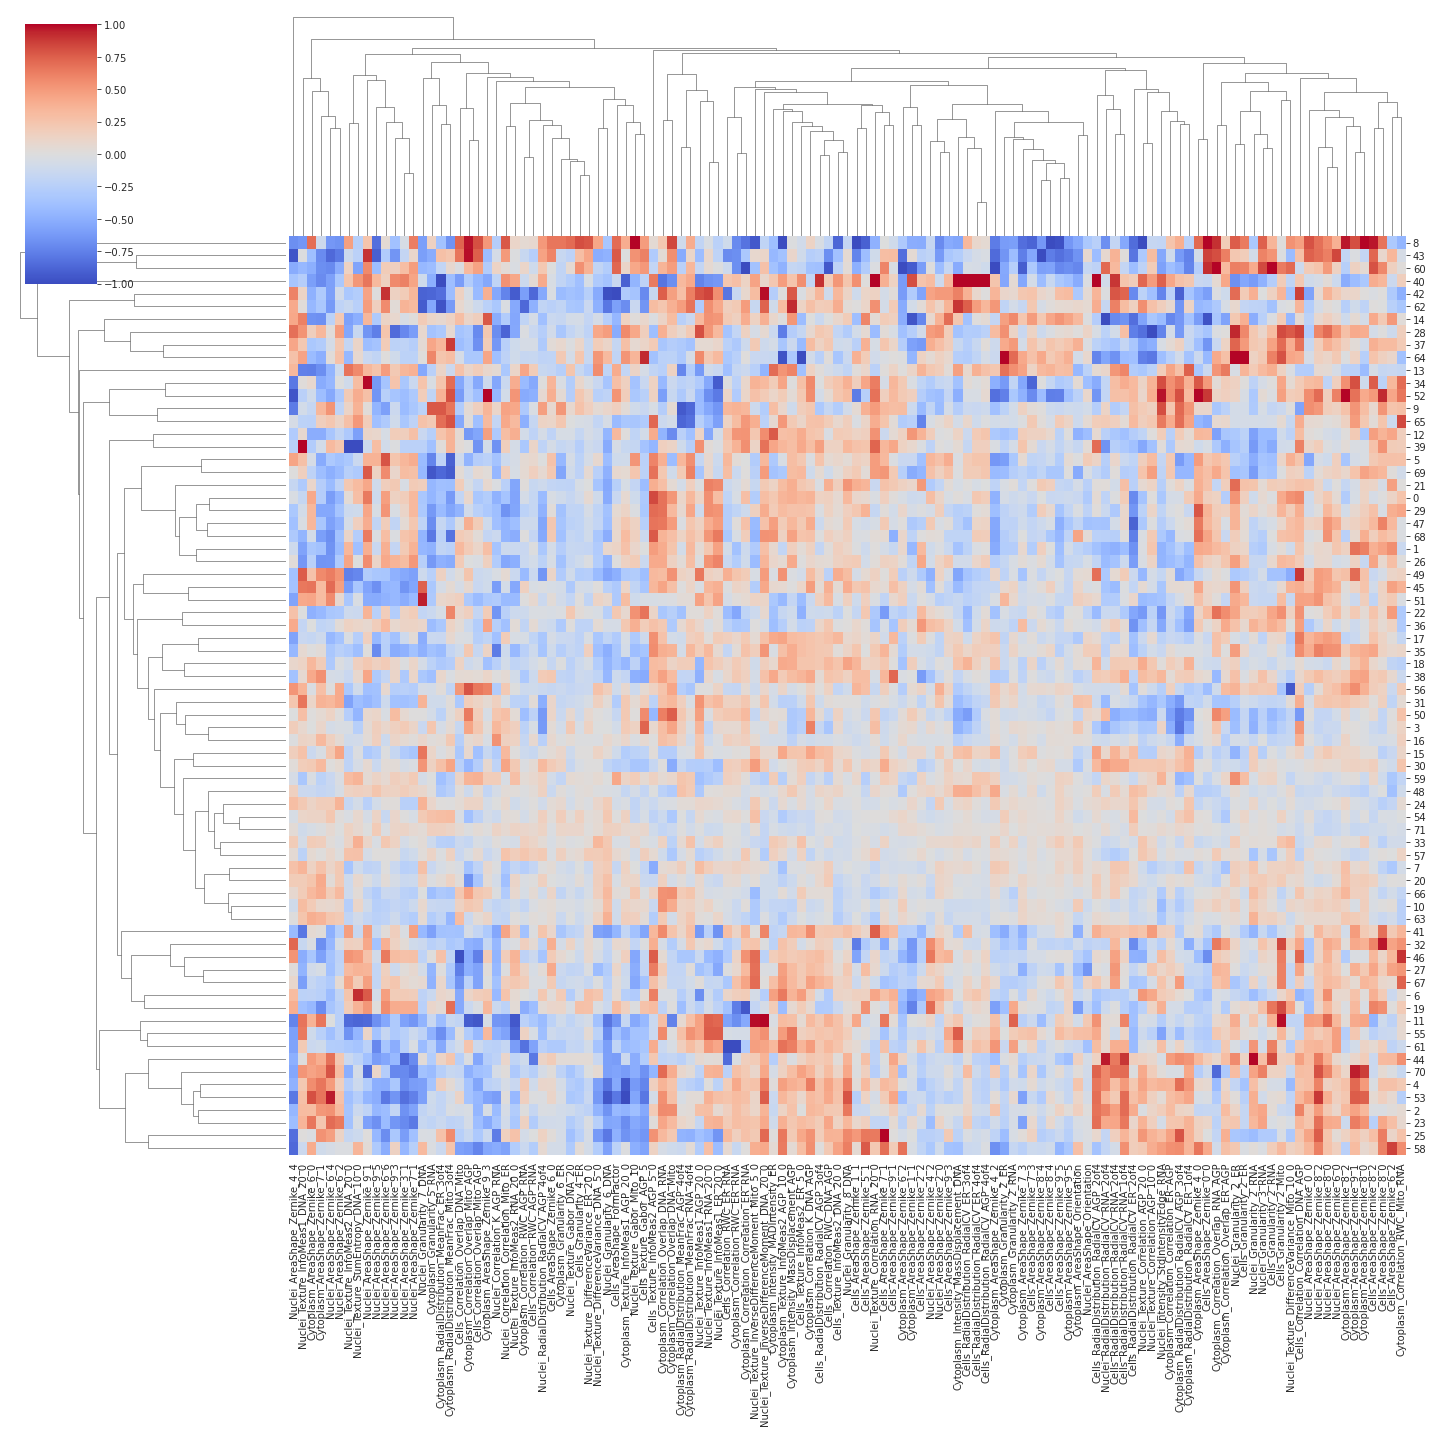

In [89]:
sns.clustermap(cp_scaled_1range_sel_perts[cp_features],figsize=(20, 20),xticklabels=1,yticklabels=1,cmap="coolwarm");

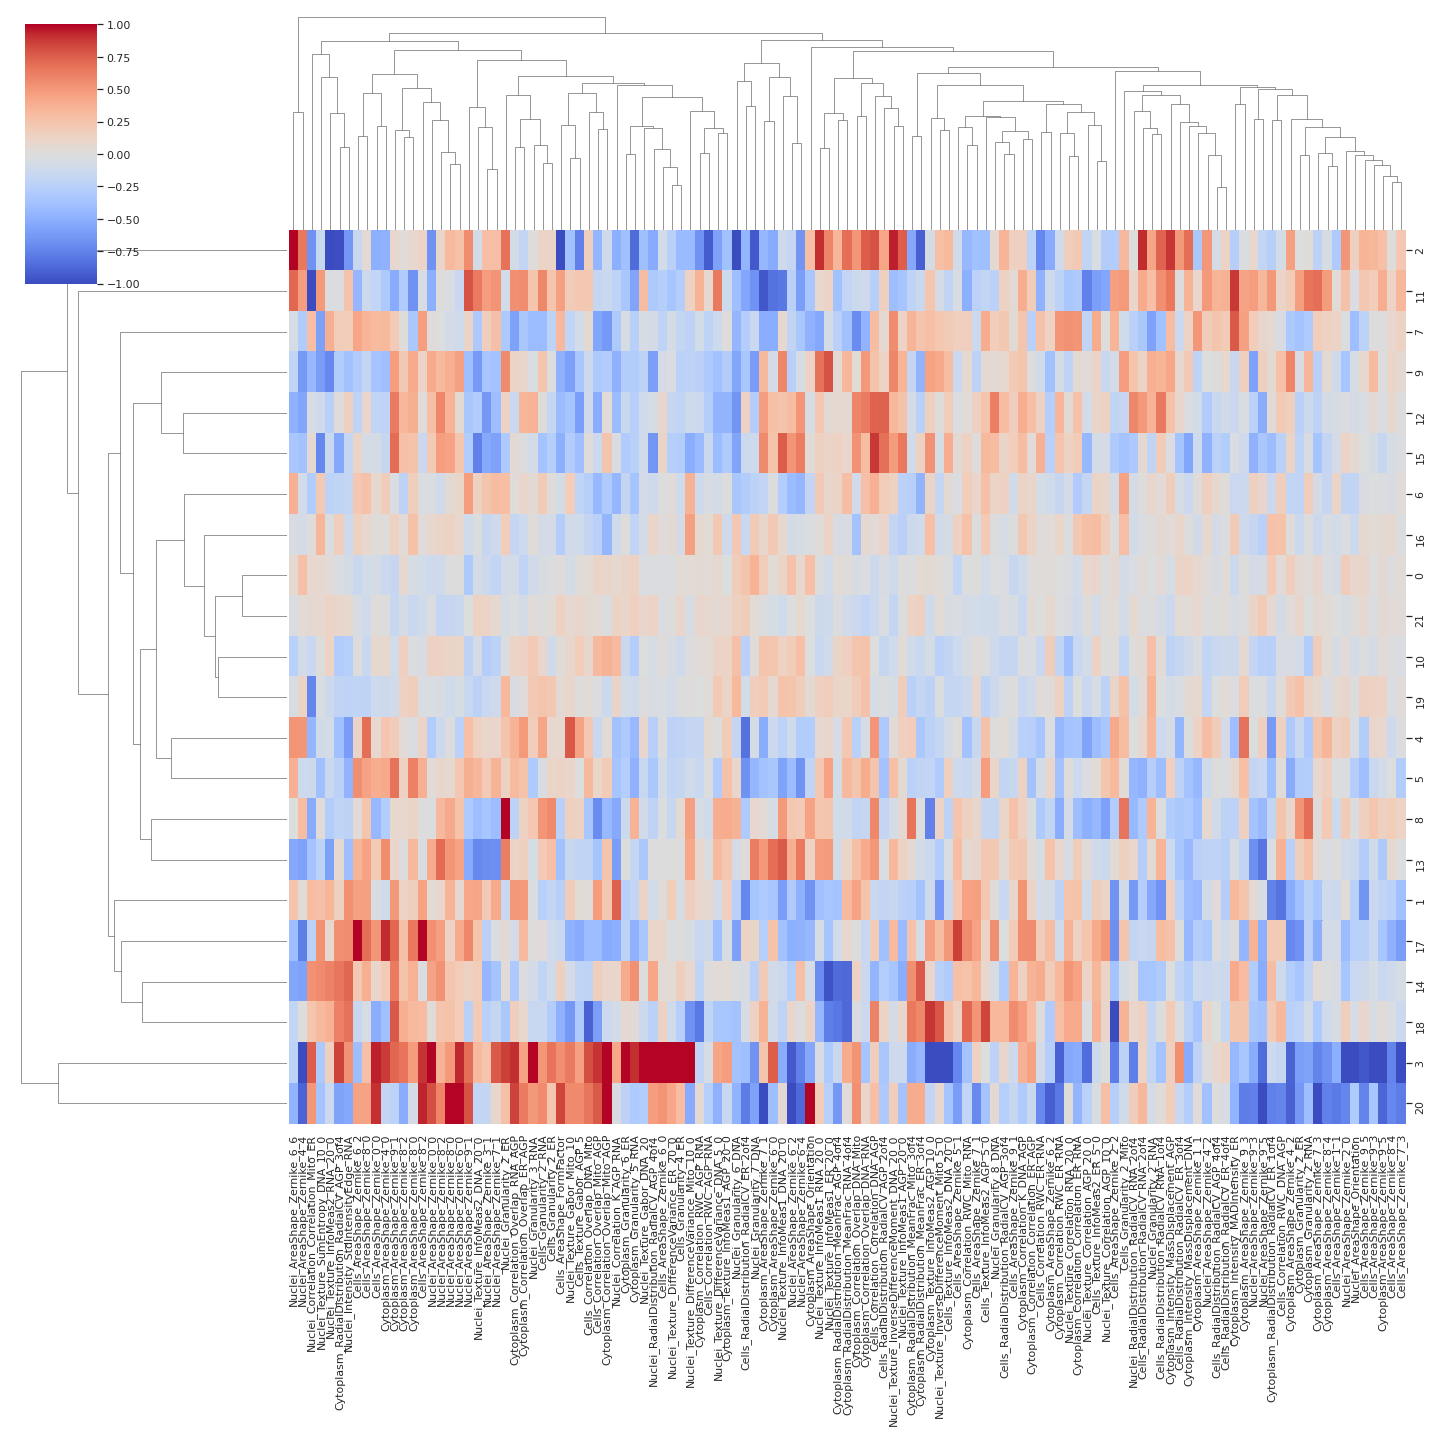

In [169]:
# plt.figure()
# %matplotlib tk
# %matplotlib inline
sns.clustermap(cp_scaled_1range_sel_perts[cp_features],figsize=(20, 20),xticklabels=1,yticklabels=1,cmap="coolwarm");

In [153]:
# 
species

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: species, Length: 150, dtype: object

In [115]:
# procProf_dir='/home/ubuntu/datasetsbucket/Rosetta-GE-CP/'
def find_correlation(data, threshold=0.9, remove_negative=False):
    
    """
    Source/reference:  https://gist.github.com/Swarchal/e29a3a1113403710b6850590641f046c#file-find_correlation-py
    Given a numeric pd.DataFrame, this will find highly correlated features,
    and return a list of features to remove.
    Parameters
    -----------
    data : pandas DataFrame
        DataFrame
    threshold : float
        correlation threshold, will remove one of pairs of features with a
        correlation greater than this value.
    remove_negative: Boolean
        If true then features which are highly negatively correlated will
        also be returned for removal.
    Returns
    --------
    select_flat : list
        listof column names to be removed
    """
    corr_mat = data.corr()
    if remove_negative:
        corr_mat = np.abs(corr_mat)
    corr_mat.loc[:, :] = np.tril(corr_mat, k=-1)
    already_in = set()
    result = []
    for col in corr_mat:
        perfect_corr = corr_mat[col][corr_mat[col] > threshold].index.tolist()
        if perfect_corr and col not in already_in:
            already_in.update(set(perfect_corr))
            perfect_corr.append(col)
            result.append(perfect_corr)
    select_nested = [f[1:] for f in result]
    select_flat = [i for j in select_nested for i in j]
    return select_flat

In [118]:
l1k_scaled_1range_sel_perts.shape

(22, 985)

In [121]:
features_to_remove =find_correlation(l1k_scaled_1range[l1k_features], threshold=0.9, remove_negative=False)

In [120]:
len(features_to_remove), features_to_remove

(17,
 ['200814_at',
  '206254_at',
  '209747_at',
  '206109_at',
  '221081_s_at',
  '204369_at',
  '201058_s_at',
  '218457_s_at',
  '203639_s_at',
  '210058_at',
  '205498_at',
  '202637_s_at',
  '217871_s_at',
  '207042_at',
  '204106_at',
  '200789_at',
  '212665_at'])

In [122]:
len(features_to_remove), features_to_remove

(0, [])

In [132]:
from sklearn.decomposition import PCA
pca = PCA(n_components=40)
principalComponents = pca.fit_transform(l1k_scaled_1range[l1k_features])
pc_col_names=['pc'+str(i) for i in range(40)]
l1k_scaled_1range[pc_col_names]=principalComponents
# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['principal component 1', 'principal component 2'])

In [135]:
pc_col_names=['pc'+str(i) for i in range(40)]

In [124]:
pca.explained_variance_ratio_

array([0.13599212, 0.06336653])

In [130]:
var_exp=pca.explained_variance_ratio_

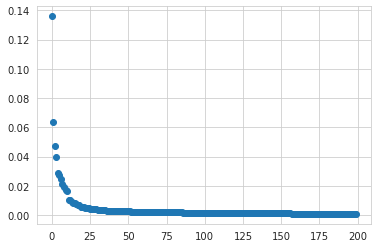

In [131]:
plt.figure()
plt.scatter(range(len(var_exp)),var_exp)

### Schematic for MNIST to put as a figure on the paper

In [10]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
# import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

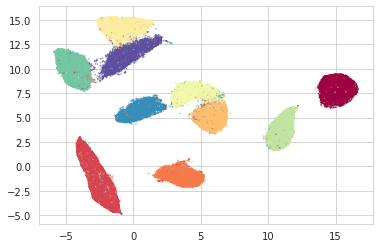

In [11]:
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(int)

standard_embedding = umap.UMAP(random_state=42).fit_transform(mnist.data)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=mnist.target.astype(int), s=0.1, cmap='Spectral');


### UMAP of Single of 22 selected perturbations

In [29]:
##################### save single cell profiles corresponding to images saved
save_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/gan_l1k_ssCP_data/'
pert_df_allP=pd.read_pickle(save_dir+"/ims_array_sc_df.pkl")

indices_test =[0,1,3,4,6,7,8,10,11,12,14]; #test
# indices_test =[1,3,4,6,7,8,10,21]; # filtered test
indices_train=[2,5,9,13,15,16,17,18,19,20,21]; #train

pert_df_allP.loc[pert_df_allP['label'].isin(indices_train),'subset']='train'
pert_df_allP.loc[pert_df_allP['label'].isin(indices_test),'subset']='test'

In [23]:
# pert_df_allP['label'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [67]:
umapT=umap.UMAP()
Y = umapT.fit_transform(pert_df_allP[cp_features])
pert_df_allP['one']=Y[:,0]
pert_df_allP['two']=Y[:,1]
# plt.figure(figsize=(15,15))
# sns.scatterplot(x="one", y="two", hue="label",style="modality", data=pert_df_allP,legend=False);
pert_df_allP.loc[pert_df_allP['label']==21,'subset']="control"
# sns.color_palette("Spectral", as_cmap=True)

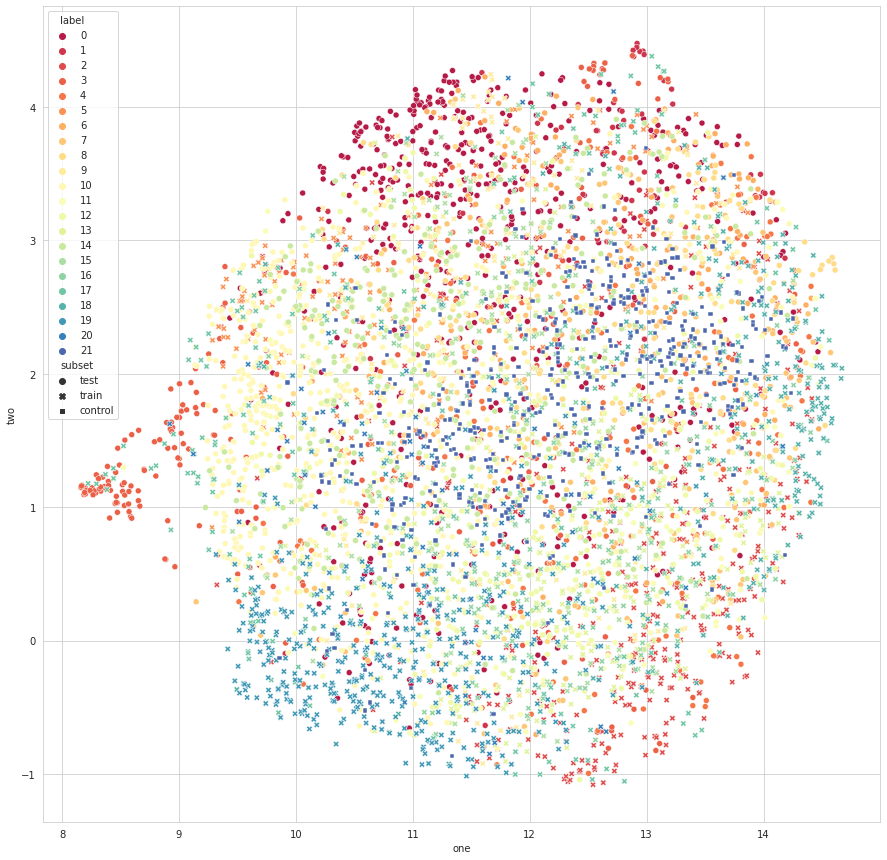

In [68]:
plt.figure(figsize=(15,15))
sns.scatterplot(x="one", y="two", hue="label", data=pert_df_allP,style="subset",\
                legend='full',palette = sns.color_palette("Spectral", 22));

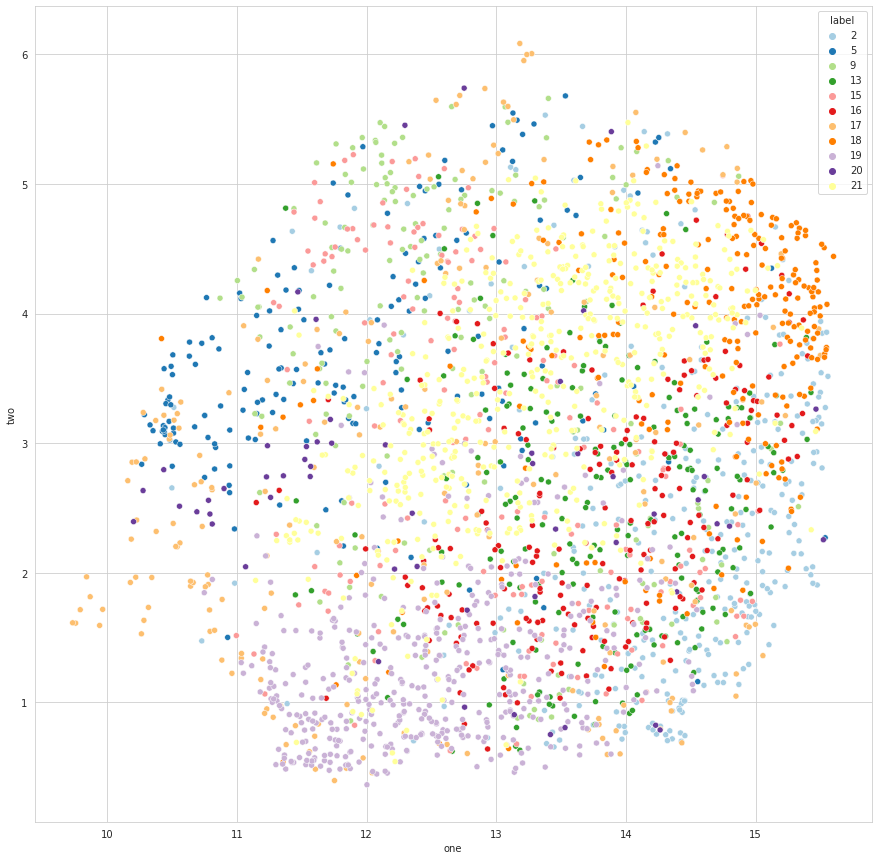

In [62]:
plt.figure(figsize=(15,15))
sns.scatterplot(x="one", y="two", hue="label", data=pert_df_allP.loc[pert_df_allP['subset']=='train'],\
     legend='full',palette = sns.color_palette("Paired", 11));
# sns.color_palette("Paired")
# sns.color_palette("bright", 11)

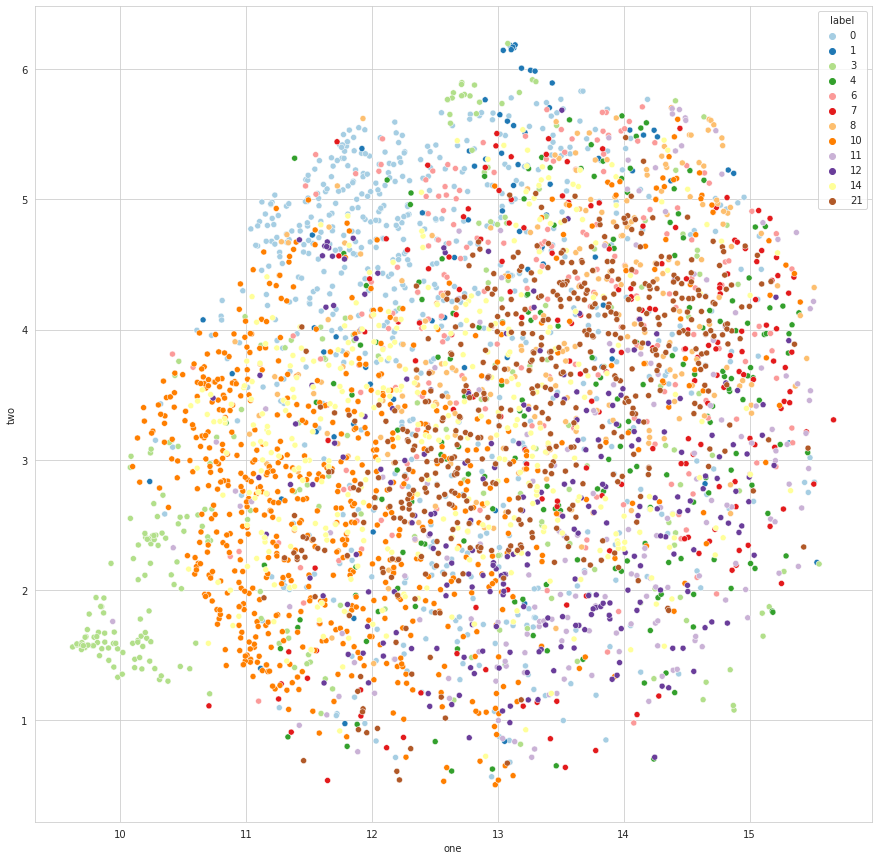

In [50]:
plt.figure(figsize=(15,15))
sns.scatterplot(x="one", y="two", hue="label", data=pert_df_allP.loc[(pert_df_allP['subset']=='test')|(pert_df_allP['label']==21)],\
     legend='full',palette = sns.color_palette("Paired", 12));

In [1]:
plt.figure(figsize=(15,15))
sns.scatterplot(x="one", y="two", hue="label", data=pert_df_allP,\
     legend='full',palette = sns.color_palette("Paired", 22));

NameError: name 'plt' is not defined

In [57]:
sns.color_palette("tab20")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]